In [ ]:
!pip install --quiet torchviz

  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import numpy as np
from torchviz import make_dot
from IPython.display import display,Math,Latex

for c in [torch,np]:
  print(c.__version__)

2.2.1+cu121
1.25.2


#Linear Regression
$$y=\textbf{w}^T \textbf{x} + b$$
* 엄밀하게 얘기하면 affine transform(not linear transform)

##Fahrenheit vs Celcius
from Fahrenheit(`x`) to Celcius(`y`)

 $$y=1.8 \times x + 32$$

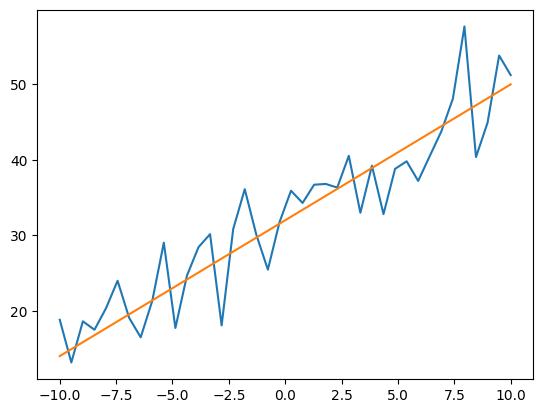

In [ ]:
x= np.linspace(-10,10, 40)
y_ideal= 1.8 * x + 32.
y= y_ideal + 4.*np.random.randn((40))

import matplotlib.pyplot as plt
plt.plot(x,y, x,y_ideal)



In [ ]:
y=torch.tensor(y).float()
x=torch.tensor(x).float()

print(y.dtype, y.shape)
print(x.dtype, x.shape)

torch.float32 torch.Size([40])
torch.float32 torch.Size([40])


##Model and Loss

In [ ]:
def ds_linear_model(x,w,b):
    ret_v=w*x+b
    return ret_v

In [ ]:
def loss_fnc(pred,label):
  mse = ((pred-label)**2).mean()
  return mse

## init model

In [ ]:
w=torch.ones(())
b=torch.zeros(())

w,b

(tensor(1.), tensor(0.))

##Prediction

In [ ]:
pred =  ds_linear_model(x,w,b)
pred

tensor([-10.0000,  -9.4872,  -8.9744,  -8.4615,  -7.9487,  -7.4359,  -6.9231,
         -6.4103,  -5.8974,  -5.3846,  -4.8718,  -4.3590,  -3.8462,  -3.3333,
         -2.8205,  -2.3077,  -1.7949,  -1.2821,  -0.7692,  -0.2564,   0.2564,
          0.7692,   1.2821,   1.7949,   2.3077,   2.8205,   3.3333,   3.8462,
          4.3590,   4.8718,   5.3846,   5.8974,   6.4103,   6.9231,   7.4359,
          7.9487,   8.4615,   8.9744,   9.4872,  10.0000])

##Loss

In [ ]:
l=loss_fnc(pred+1,pred)
l

tensor(1.)

###Gredient Descent Algorithm

### weights


$$ w_{t+1} = w_{t} - \eta \nabla_{w} L(w_t, X, Y)$$

$$\begin{align}\nabla_{w} L(w_t, X, Y) &=\frac{ \partial L(w_t, X, Y)}{
\partial w}\\ &\approx \frac{L(w_t+ \delta, X, Y) - L(w_t - \delta, X, Y)}{2\delta} \end{align}$$


In [ ]:

delta=0.1
lr = 1e-3 #0.001

d_loss_d_w= (loss_fnc(ds_linear_model(x, w+delta, b), y) - loss_fnc(ds_linear_model(x, w-delta, b), y)) / (2. * delta)

tmp= d_loss_d_w.detach().numpy()
print(tmp)

display( Math(r'\frac{ \partial L(w_t, X, Y)}{\partial w} \approx'+ str(tmp)))



-48.670654


<IPython.core.display.Math object>

###bais

$$ b_{t+1} = b_{t} - \eta \nabla_{w} L(b_t, X, Y)$$

$$\begin{align}\nabla_{b} L(b_t, X, Y) &= \frac{ \partial L(b_t, X,
Y)}{
  \partial b}\\ &\approx \frac{L(b_t + \delta, X, Y) - L(b_t - \delta, X, Y)}{2\delta} \end{align}$$

  

In [ ]:
d_loss_d_b = (loss_fnc(ds_linear_model(x, w, b+delta), y) - loss_fnc(ds_linear_model(w, w, b-delta), y)) / (2.*delta)

tmp=d_loss_d_w.detach().numpy()
print(tmp)
display( Math(r'\frac{ \partial L(b_t, X, Y)}{\partial b} \approx'+str(tmp)))

-48.670654


<IPython.core.display.Math object>

### update parameters

In [ ]:
w = w - lr * d_loss_d_w
b = b - lr * d_loss_d_b

w,b

(tensor(1.0487), tensor(0.1639))

In [ ]:
print(f'current loss:{l=}')
pred=ds_linear_model(x,w,b)
l_new=loss_fnc(pred, y)
print(f'new loss:{l_new=}')

current loss:l=tensor(1.)
new loss:l_new=tensor(1067.3281)


---
#Analytical Derivatives


In [ ]:
def anal_d_loss_d_pred(pred,y):
  ret_v = 2. *(pred-y)
  return ret_v
def anal_d_pred_d_w(x,w,b):
  return x

def anal_d_pred_d_b(w,x,b):
  return 1.

$$
\nabla L = \begin{bmatrix} \frac{dL}{dw} \\
\frac{dL}{db} \end{bmatrix}$$

In [ ]:
def get_grad(x,y,pred,w,b):
  v_d_loss_d_pred = anal_d_loss_d_pred(pred, y)
  v_d_loss_d_w = v_d_loss_d_pred * anal_d_pred_d_w(x,w,b)
  v_d_loss_d_b = v_d_loss_d_pred * anal_d_pred_d_b(x,w,b)

  return torch.stack([v_d_loss_d_w.mean(), v_d_loss_d_b.mean()])


In [ ]:
from sys import get_coroutine_origin_tracking_depth
w_init = 1.
b_init = 0.

preds = ds_linear_model(x, w_init, b_init)
l = loss_fnc(preds,y)

grad = get_grad(x, y, preds, w, b)

display(f'{grad=}')

'grad=tensor([-48.6708, -64.6692])'

#Training

In [ ]:
def ds_training(x, y, model, _w, _b, n_epoch, lr, log_flag=False):

    w, b = _w, _b
    for epoch in range(n_epoch):


      pred = model(x, w, b)
      l = loss_fnc(pred, y)

      if torch.isinf(l).any():
        print('Error:loss is infinity.')
        print(f'{epoch=}')
        break

      grad = get_grad(x, y, pred, w, b)
      w = w - lr* grad[0]
      b = b - lr* grad[1]



      if epoch in [0,1,2,3,4,5, 100, 1000, 2000, 3000, 4000, 5000]:
        print(f'Epoch {epoch}: Loss {float(l):0.4f}')
        if log_flag:
          print(f'{w=},{b=}')
      elif epoch in [6,101,1001,2001,3001,4001,5001]:
        print('---')
    return w,b

In [ ]:
w_n, b_n = ds_training(
    x, y, ds_linear_model,
    torch.ones(()),
    torch.zeros(()),
    7000,
    lr = 1e-3,
)
w_n,b_n

Epoch 0: Loss 1080.1858
Epoch 1: Loss 1073.7220
Epoch 2: Loss 1067.5842
Epoch 3: Loss 1061.7302
Epoch 4: Loss 1056.1241
Epoch 5: Loss 1050.7346
---
Epoch 100: Loss 718.3164
---
Epoch 1000: Loss 36.8325
---
Epoch 2000: Loss 18.1077
---
Epoch 3000: Loss 17.7661
---
Epoch 4000: Loss 17.7598
---
Epoch 5000: Loss 17.7597
---


(tensor(1.6944), tensor(32.3336))

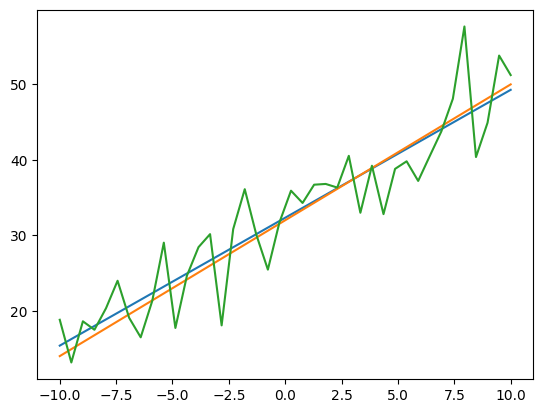

In [ ]:
pred = ds_linear_model(x, w_n,b_n)
plt.plot(x, pred, x, y_ideal, x, y)

# Torch's AutoGrad

In [ ]:
params = torch.tensor(
    [1., 0.],
    requires_grad=True
)

if params.grad is None:
  print('"grad" attributes \'s default is None.')

"grad" attributes 's default is None.


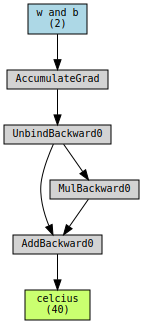

In [ ]:
pred= ds_linear_model(x, *params)
cg = make_dot(pred, params = {'w and b': params, ' celcius':pred })
display(cg)

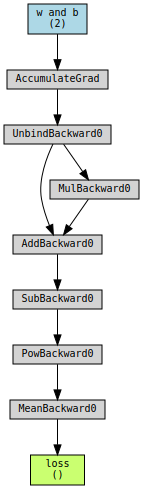

In [ ]:
l = loss_fnc(pred, y)
cg = make_dot(l, params={'loss':l,'w and b': params })
display(cg)

In [ ]:
l.backward()
params.grad


tensor([-48.6708, -64.6692])

In [ ]:
if params.grad is not None:
  params.grad.zero_()
  params.grad

In [ ]:
def ds_training_auto (x, y, model, params , n_epoch, lr, log_flag = False):
  for epoch in range(n_epoch):
    if params.grad is not None:
      params.grad.zero_()

    pred = model(x,*params) # pred = model(x, params[0], parmas[1])
    l = loss_fnc(pred, y)
    if torch.isinf(l).any():
      print('Error: loss is infinity.')
      print(f'{epoch=}')
      break

    l.backward()

    with torch.no_grad():
      params -= lr * params.grad

    if epoch % 2000 == 0:
      print(f'Epoch {epoch}: Loss {float(l):0.4f}')
      if log_flag:
        print(f'{w=}, {b=}')

  return params

In [ ]:
params = torch.tensor(
    [1.0, 0.0],
    requires_grad = True
)

params = ds_training_auto(
    x, y,
    model = ds_linear_model,
    params = params,
    n_epoch = 7000,
    lr = 1e-3,
)

display(params)

Epoch 0: Loss 1080.1858
Epoch 2000: Loss 18.1077
Epoch 4000: Loss 17.7598
Epoch 6000: Loss 17.7597


tensor([ 1.6944, 32.3336], requires_grad=True)

# torch.optim 의 사용.

Gradient Descent를 PyTorch의 optim 모듈을 사용한 구현.

In [ ]:
import torch.optim as optim
dir(optim)


['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [ ]:
params = torch.tensor(
    [1. ,0.],
    requires_grad=True ,
)

display(params)


lr = 1e-3
optimizer = optim.SGD(
    [params],
    lr=lr,
)

pred=ds_linear_model(x,*params)
l=loss_fnc(pred, y)

optimizer.zero_grad()
l.backward()
optimizer.step()

display(params)

tensor([1., 0.], requires_grad=True)

tensor([1.0487, 0.0647], requires_grad=True)

In [ ]:
def ds_training_optim (
    x,y,
    model, params,
    n_epoch,
    optimizer,log_flag=False):

  for epoch in range(n_epoch):



    pred = model(x,*params)
    l = loss_fnc(pred, y)

    if torch.isinf(l).any():
      print('Errror: loss is infinity.')
      print(f'{epoch=}')
      break

    optimizer.zero_grad()
    l.backward()
    optimizer.step()


    if epoch %2000==0:
     print(f'Epoch {epoch}: Loss {float(l):0.4f}')
     if log_flag:
      print(f'{w=},{b=}')

  return params

In [ ]:
params = torch.tensor(
    [1.,0.],
    requires_grad=True,
)

lr=1e-3
optimizer=optim.SGD(
    [params],
    lr = lr
)
ds_training_optim(x,y,ds_linear_model, params, 6000, optimizer )


Epoch 0: Loss 1080.1858
Epoch 2000: Loss 18.1077
Epoch 4000: Loss 17.7598


tensor([ 1.6944, 32.3336], requires_grad=True)

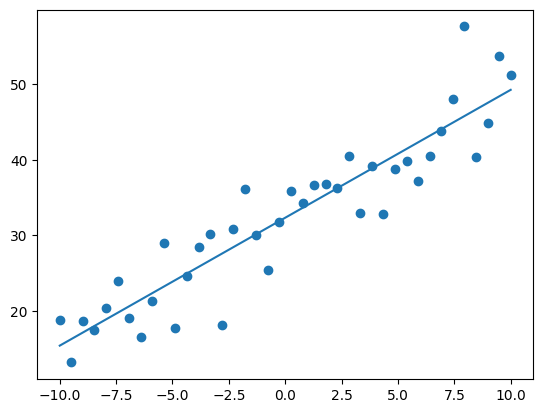

In [ ]:
pred = ds_linear_model(x,*params)
plt.scatter(x,y)
plt.plot(x, pred.detach().numpy())
plt.show()

토치의 뉴럴 네트워크라는 스페이스
-리니어를 같은 로직으로 동작 텐서간의 곱,